# Análise de Sentimentos - Twitter

Identificar se o tweet é **racista/sexista** ou **não**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

import re

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

### Ler dados

In [2]:
train = pd.read_csv('twitter/train.csv')
test = pd.read_csv('twitter/test.csv')

In [3]:
train.shape, test.shape

((31962, 3), (17197, 2))

In [5]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


## Pré-processamento de Dados

### Tirar pontuações e caracteres especiais

In [6]:
def limpa_texto(data, col):
    """
    Retira pontuações e caracteres especiais, recebendo como parâmetros o DataFrame (data) e a coluna (col)
    """
    data[col] = data[col].str.lower()
    data[col] = data[col].apply(lambda x: re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?', '', x))

In [7]:
limpa_texto(train, 'tweet')

In [8]:
limpa_texto(test, 'tweet')

In [9]:
train.head()

,id,label,tweet
0,1,0,when a father is dysfunctional and is so sel...
1,2,0,thanks for lyft credit i cant use cause they...
2,3,0,bihday your majesty
3,4,0,model i love u take with u all the time in u...
4,5,0,factsguide society now motivation


In [10]:
test.head()

,id,tweet
0,31963,studiolife aislife requires passion dedication...
1,31964,white supremacists want everyone to see the ...
2,31965,safe ways to heal your acne altwaystoheal h...
3,31966,is the hp and the cursed child book up for res...
4,31967,3rd bihday to my amazing hilarious nephew el...


### Remover palavras comuns

In [11]:
def remove_palavras_comuns(data, col):
    palavras_comuns = stopwords.words('english')
    lista_de_lista_de_palavras = data[col].str.split()
    for idx, _ in data.iterrows():
        data[col].at[idx] = [palavra for palavra in lista_de_lista_de_palavras[idx]\
                             if palavra not in palavras_comuns]

In [12]:
remove_palavras_comuns(train, 'tweet')

In [13]:
remove_palavras_comuns(test, 'tweet')

In [14]:
train.head()

,id,label,tweet
0,1,0,"[father, dysfunctional, selfish, drags, kids, ..."
1,2,0,"[thanks, lyft, credit, cant, use, cause, dont,..."
2,3,0,"[bihday, majesty]"
3,4,0,"[model, love, u, take, u, time, ur]"
4,5,0,"[factsguide, society, motivation]"


In [15]:
test.head()

,id,tweet
0,31963,"[studiolife, aislife, requires, passion, dedic..."
1,31964,"[white, supremacists, want, everyone, see, new..."
2,31965,"[safe, ways, heal, acne, altwaystoheal, health..."
3,31966,"[hp, cursed, child, book, reservations, alread..."
4,31967,"[3rd, bihday, amazing, hilarious, nephew, eli,..."


### Remover variações da mesma palavra

In [16]:
def tira_variacao_de_palavras(data, col):
    tira_variacao = WordNetLemmatizer()
    for idx, _ in data.iterrows():
        data[col].at[idx] = [tira_variacao.lemmatize(palavra, 'v')\
                             for palavra in data[col][idx]]

In [17]:
tira_variacao_de_palavras(train, 'tweet')

In [18]:
tira_variacao_de_palavras(test, 'tweet')

In [19]:
train.tail(10)

,id,label,tweet
31952,31953,0,"[go, far]"
31953,31954,0,"[good, morning, instagram, shower, water, berl..."
31954,31955,0,"[holiday, bull, dominate, bull, direct, whatev..."
31955,31956,0,"[less, 2, weeks, ibizabringitonmallorcaholiday..."
31956,31957,0,"[fish, tomorrow, carnt, wait, first, time, 2, ..."
31957,31958,0,"[eat, isz, youuu]"
31958,31959,0,"[see, nina, turner, airwaves, try, wrap, mantl..."
31959,31960,0,"[listen, sad, songs, monday, morning, otw, wor..."
31960,31961,1,"[sikh, temple, vandalise, calgary, wso, condem..."
31961,31962,0,"[thank, follow]"


### Engenharia de Recursos (Feature Engineering ) 
#### Quantidade de palavras por tweet

In [20]:
train['palavras'] = train['tweet'].apply(len)

In [21]:
test['palavras'] = train['tweet'].apply(len)

In [22]:
train

,id,label,tweet,palavras
0,1,0,"[father, dysfunctional, selfish, drag, kid, dy...",7
1,2,0,"[thank, lyft, credit, cant, use, cause, dont, ...",13
2,3,0,"[bihday, majesty]",2
3,4,0,"[model, love, u, take, u, time, ur]",7
4,5,0,"[factsguide, society, motivation]",3
...,...,...,...,...
31957,31958,0,"[eat, isz, youuu]",3
31958,31959,0,"[see, nina, turner, airwaves, try, wrap, mantl...",14
31959,31960,0,"[listen, sad, songs, monday, morning, otw, wor...",8
31960,31961,1,"[sikh, temple, vandalise, calgary, wso, condem...",7


## Análise Exploratória de Dados (AED)

### Distribuição das quantidades de palavras por "label"

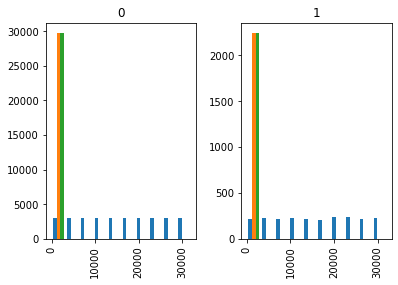

In [23]:
train.hist(column=['palavras'], by='label')
plt.show()

### Quantidade de cada "label"

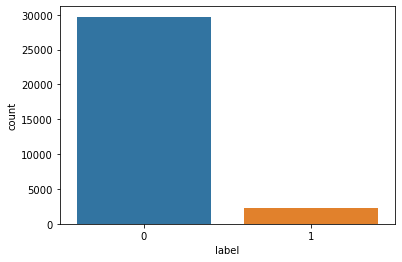

In [24]:
sns.countplot('label', data=train)
plt.show()

### Palavras frequêntes

#### Averiguar palavras mais frequêntes classificadas como "racistas ou sexistas"

In [25]:
lista_de_listas = train.loc[train['label'] == 1]['tweet'].values
lista_de_listas

array([list(['cnn', 'call', 'michigan', 'middle', 'school', 'build', 'wall', 'chant', 'tcot']),
       list(['comment', 'australia', 'opkillingbay', 'seashepherd', 'helpcovedolphins', 'thecove', 'helpcovedolphins']),
       list(['retweet', 'agree']), ...,
       list(['dont', 'ball', 'hashtag', 'say', 'weasel', 'away', 'lumpy', 'tony', 'dipshit']),
       list(['make', 'ask', 'anybody', 'god', 'oh', 'thank', 'god']),
       list(['sikh', 'temple', 'vandalise', 'calgary', 'wso', 'condemn', 'act'])],
      dtype=object)

In [26]:
palavras = [palavra for lista in lista_de_listas for palavra in lista]

In [27]:
len(palavras)

18596

In [28]:
import collections

In [29]:
def gera_freq_palavras(lista):
    return collections.Counter(lista)

In [30]:
freq_palavras = gera_freq_palavras(palavras)

In [31]:
len(freq_palavras)

5285

In [32]:
lista_de_palavras = []
lista_de_frequencias = []

for palavra, frequencia in freq_palavras.items():
    lista_de_palavras.append(palavra)
    lista_de_frequencias.append(frequencia)

In [33]:
data_freq = pd.DataFrame({'palavra': lista_de_palavras, 'freq': lista_de_frequencias})

In [34]:
data_freq.sort_values('freq', ascending=False, inplace=True)

In [35]:
dict(data_freq[:10].values)

{'amp': 283,
 'trump': 216,
 'white': 153,
 'libtard': 149,
 'black': 146,
 'like': 141,
 'racist': 103,
 'politics': 97,
 'say': 96,
 'people': 95}

### Nuvem de Palavras 

In [36]:
from wordcloud import WordCloud

In [37]:
nuvem = WordCloud(background_color='white')

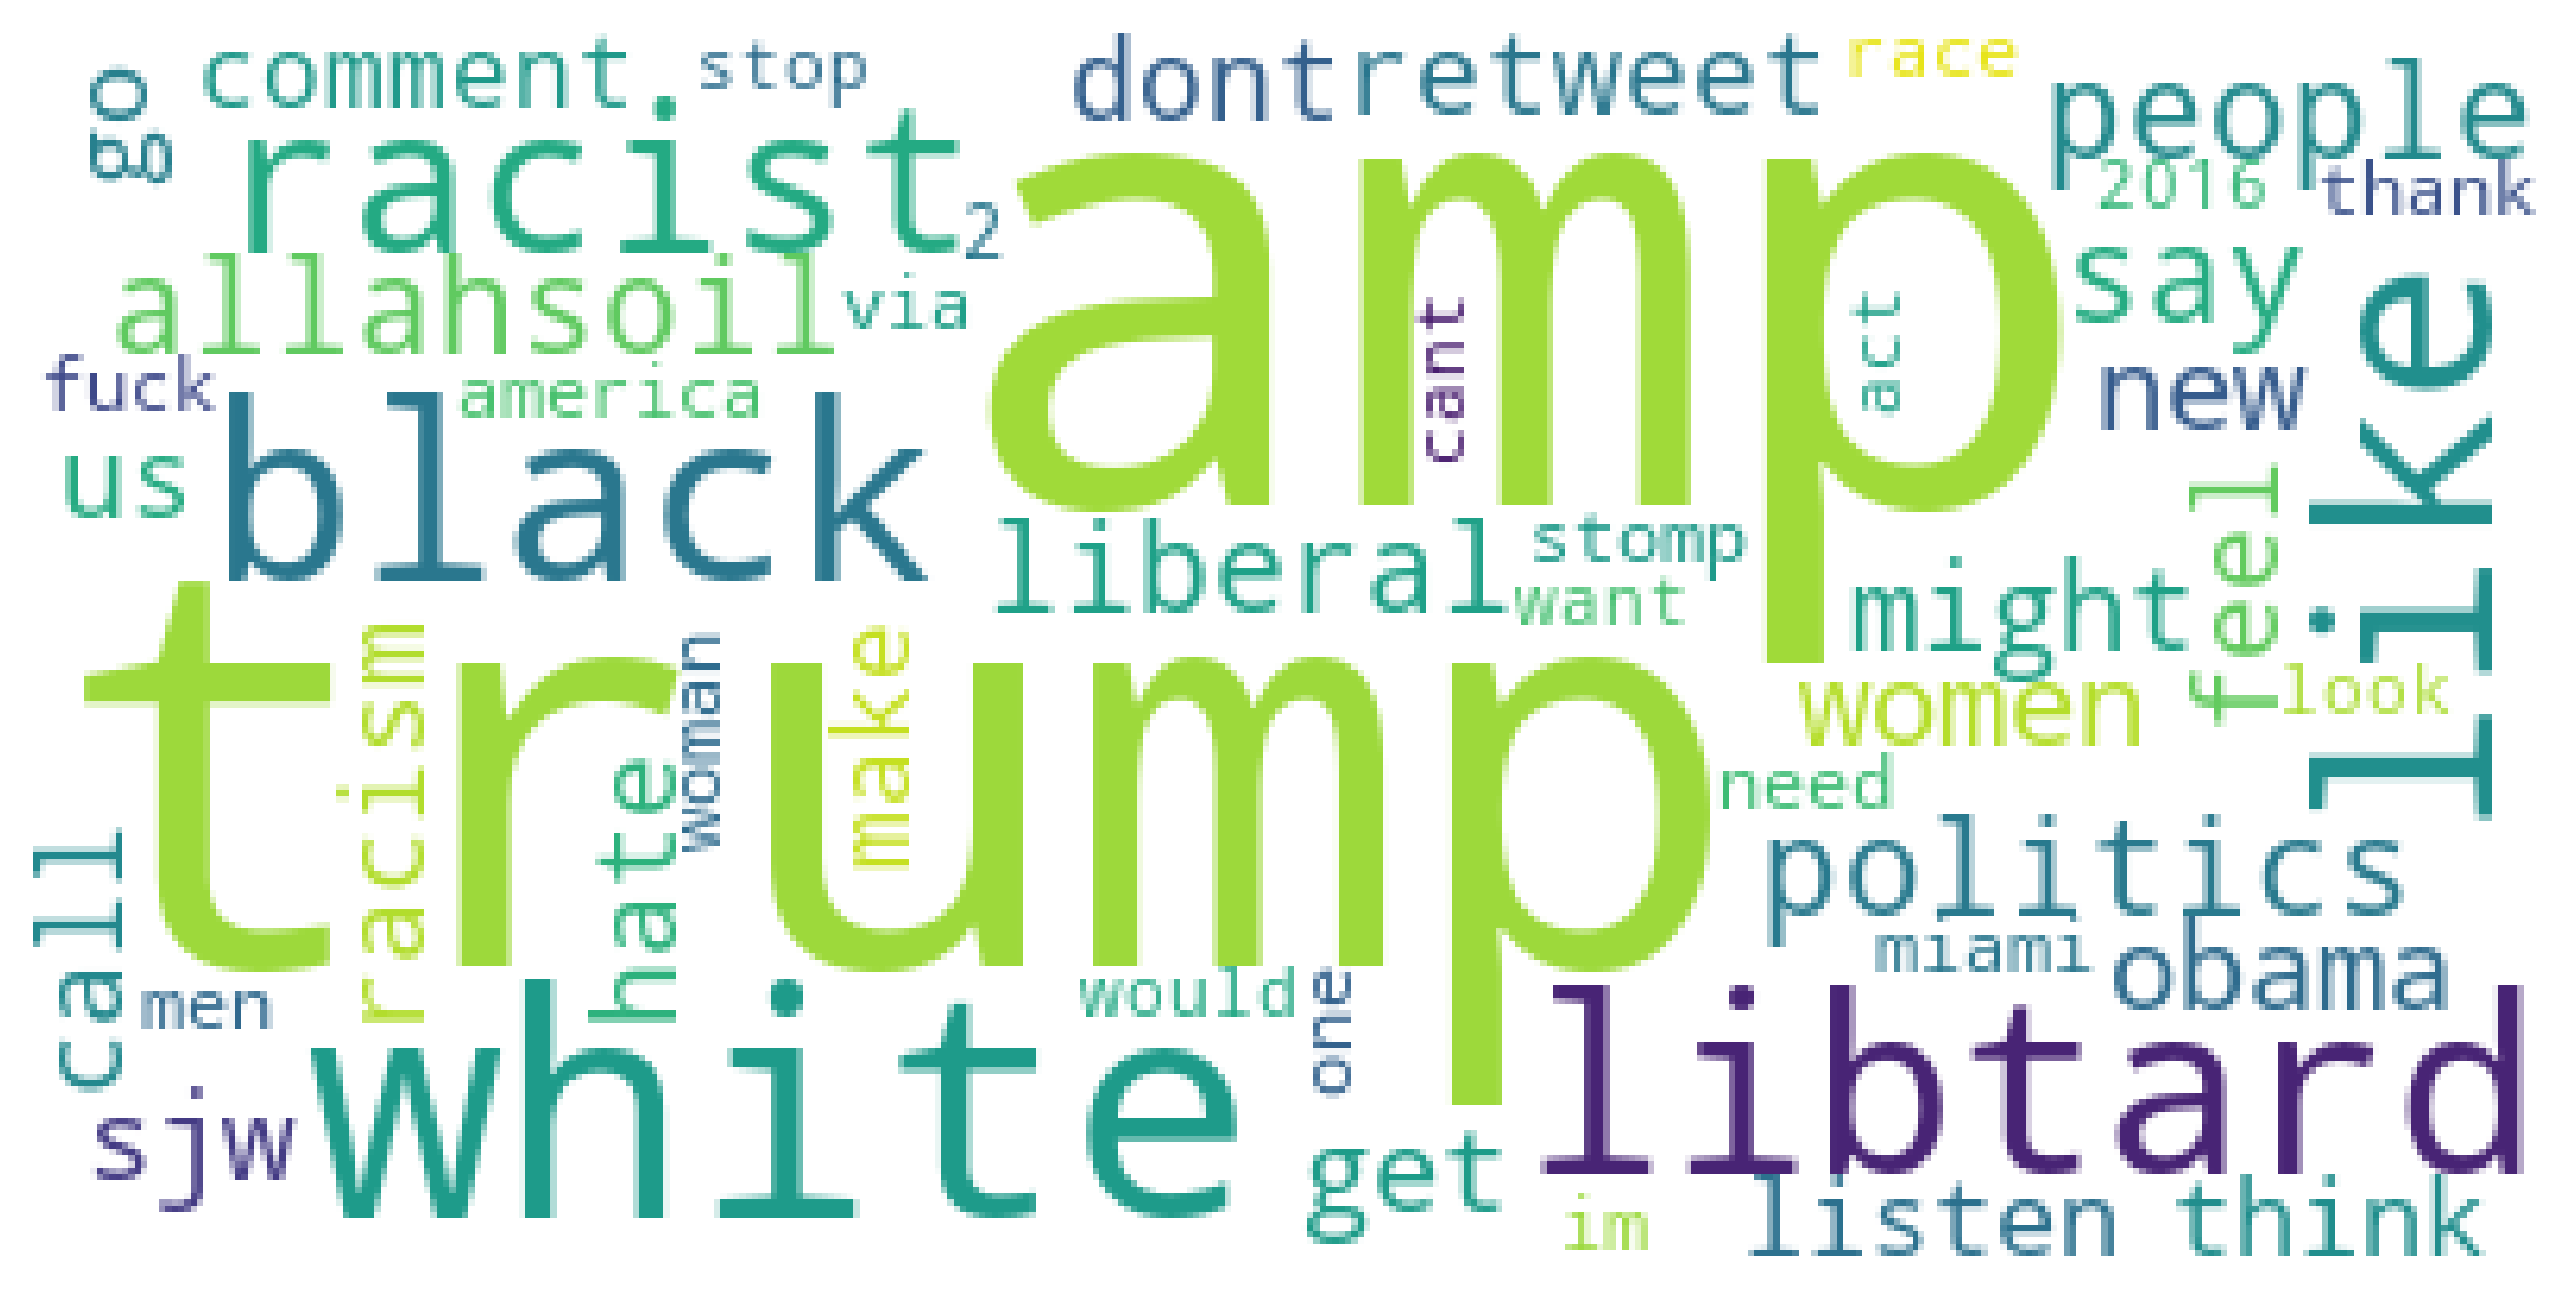

In [38]:
plt.figure(figsize=(12,8), dpi=300)
nuvem.generate_from_frequencies(dict(data_freq[:50].values))
plt.imshow(nuvem)
plt.axis('off')
plt.show()

### Retornar para formato de texto

In [39]:
train['tweet'] = train['tweet'].apply(lambda x: ' '.join(x))

In [40]:
test['tweet'] = test['tweet'].apply(lambda x: ' '.join(x))

In [41]:
train

,id,label,tweet,palavras
0,1,0,father dysfunctional selfish drag kid dysfunct...,7
1,2,0,thank lyft credit cant use cause dont offer wh...,13
2,3,0,bihday majesty,2
3,4,0,model love u take u time ur,7
4,5,0,factsguide society motivation,3
...,...,...,...,...
31957,31958,0,eat isz youuu,3
31958,31959,0,see nina turner airwaves try wrap mantle genui...,14
31959,31960,0,listen sad songs monday morning otw work sad,8
31960,31961,1,sikh temple vandalise calgary wso condemn act,7


###  Solucionar problema de desequilibrio dos dados

In [42]:
from sklearn.utils import resample

In [43]:
def equilibra_dados(train, pra_mais=True):
    train_minoria = train.loc[train['label'] == 1]
    train_maioria = train.loc[train['label'] == 0]
    if pra_mais:
        menor_pro_maior = resample(train_minoria,
                           replace=True,
                           n_samples=len(train_maioria),
                           random_state=123)
        train_equilibrado = pd.concat([menor_pro_maior, train_maioria])
    else:
        maior_pro_menor = resample(train_maioria,
                           replace=True,
                           n_samples=len(train_minoria),
                           random_state=123)
        train_equilibrado = pd.concat([maior_pro_menor, train_minoria])
    return train_equilibrado

In [62]:
train_equilibrado = equilibra_dados(train, pra_mais=True)

In [63]:
len(train_equilibrado)

59440

In [64]:
train_equilibrado['label'].value_counts()

1    29720
0    29720
Name: label, dtype: int64

## Treinar Modelo

In [65]:
X = train_equilibrado['tweet']
y = train_equilibrado['label']

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [67]:
X_train.shape, y_train.shape

((41608,), (41608,))

In [68]:
X_test.shape, y_test.shape

((17832,), (17832,))

In [69]:
sgd = Pipeline([
    ('countVector', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('modelo', SGDClassifier())
])

In [70]:
sgd.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('countVector',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabul...
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
                               max_iter=1000,

In [71]:
sgd_pred = sgd.predict(X_test)

In [72]:
sgd_pred

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

## Avaliar Performance do Modelo

In [73]:
from sklearn.metrics import f1_score

In [74]:
sgd_score = f1_score(y_test, sgd_pred)

In [75]:
sgd_score

0.9673534773242005

In [76]:
y_pred = sgd.predict(test['tweet'])
y_pred

array([0, 1, 0, ..., 1, 0, 0], dtype=int64)

## Submissão

In [77]:
submissao = pd.DataFrame({'id': test['id'], 'label': y_pred})

In [78]:
submissao.head()

,id,label
0,31963,0
1,31964,1
2,31965,0
3,31966,0
4,31967,0


In [79]:
submissao.to_csv('twitter/pred_twitter.csv', index=False)